# 
<center><h1> Homework 4: AutoEncoders
<center> Apoorv Sharma </center>
    <center> DATA 598 (Winter 2022), University of Washington </center>

# 1. Denoising AutoEncoders and Step Decay Learning Rates

In this exercise, we will use autoencoders to denoise (= de-noise, or remove the noise from) an image. We will also implement a step decay learning rate, a commonly used trick (for all deep kinds of deep nets, not just autoencoders).

Suppose we have and image x and *corrupt* it by some means to get $x' = C(x)$. Example corruptions including adding Gaussian noise or deleting random pataches in the image. A denoising autoencoder with encoder $h_w$ and decoder $g_v$ (with respective parameters w and v) takes in the corrupted input $x'$ and returns $\hat{x} = g(h(x'))$ that approximates the noise-less image x.

We will train a denoising autoencoder to reconstruct the noiseless images from the noisy ones, by minimizing the corresponding reconstruction error:

$$
\min_{w,v} \mathbb{E} \left|\left| x - g_v \circ h_w(C(x)) \right|\right|^2
$$

We will use a step decay learning rate schedule

$$
\gamma_t = \frac{\gamma_0}{2^{\lfloor t/t_o \rfloor}}
$$

in epoch $t$, where $\gamma_0$ is a given initial learning rate, and $t_0$ threshold. The learning is cut by a factor of 2 every $t_0$ epochs:

$$
\gamma_0 \dots \gamma_0, \frac{\gamma_0}{2} \dots \frac{\gamma_0}{2}, \frac{\gamma_0}{4} \dots \frac{\gamma_0}{4}
$$

A larger learning rate makes faster progress initially whereas a smaller learning rate is more helpful closer
to convergence. The step-decay schedule aims to get the best of both worlds.

In [1]:
import torch
from torch.nn.functional import relu
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import math
import pickle

### Download and Process MINST dataset
Perform the same preprocessing as in this week’s lab.

In [2]:
# download dataset (~117M in size)
train_dataset = MNIST('./data', train=True, download=True)
X_train = train_dataset.data # torch tensor of type uint8
y_train = train_dataset.targets # torch tensor of type Long
test_dataset = MNIST('./data', train=False, download=True)
X_test = test_dataset.data
y_test = test_dataset.targets

# choose a subsample of 10% of the data:
idxs_train = torch.from_numpy(
    np.random.choice(X_train.shape[0], replace=False, size=X_train.shape[0]//10)).long()
X_train, y_train = X_train[idxs_train], y_train[idxs_train]
# idxs_test = torch.from_numpy(
#     np.random.choice(X_test.shape[0], replace=False, size=X_test.shape[0]//10))
# X_test, y_test = X_test[idxs_test], y_test[idxs_test]

print(f'X_train.shape = {X_train.shape}')
print(f'n_train: {X_train.shape[0]}, n_test: {X_test.shape[0]}')
print(f'Image size: {X_train.shape[1:]}')

X_train.shape = torch.Size([6000, 28, 28])
n_train: 6000, n_test: 10000
Image size: torch.Size([28, 28])


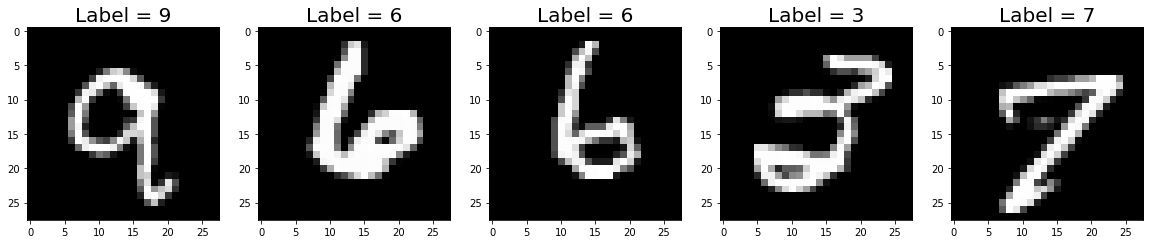

In [3]:
f, ax = plt.subplots(1, 5, figsize=(20, 4))
for i, idx in enumerate(np.random.choice(X_train.shape[0], 5)):
    ax[i].imshow(X_train[idx], cmap='gray', vmin=0, vmax=255)
    ax[i].set_title(f'Label = {y_train[idx]}', fontsize=20)

In [4]:
# NOTE: Run this cell only once. If you have to rerun it multiple times, 
# make sure that you run it after rerunning the previous 2 cells.

# Normalize dataset: pixel values lie between 0 and 255
# Normalize them so the pixelwise mean is zero and standard deviation is 1

X_train = X_train.float()  # convert to float32
# NOTE: we are returning a single mean/std over all the pixels, rather than a pixel-wise one
mean, std = X_train.mean(), X_train.std()  
X_train = (X_train - mean) / (std + 1e-6)  # avoid divide by zero
# X_train /= torch.norm(X_train, dim=(1, 2)).max()

X_test = X_test.float()
X_test = (X_test - mean) / (std + 1e-6)
# X_test /= torch.norm(X_test, dim=(1, 2)).max()

n_class = np.unique(y_train).shape[0]

### Create convolutional autoencoder
Use the same convolutional autoencoder as in this week’s lab, with a lower latent dimension of 40.

In [5]:
class EncoderModule(torch.nn.Module):
    def __init__(self, lower_dimension):
        super().__init__()
        # (B, 1, 28, 28) -> (B, 4, 12, 12)
        self.conv1 = torch.nn.Conv2d(1, 4, kernel_size=5, stride=2, padding=0) 
        self.conv2 = torch.nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=0)
        # Flatten (B, 8, 5, 5) -> (B, 8*5*5): do this in `forward()`
        # (B, 8*5*5) -> (B, lower_dimension); 8*5*5 = 200
        self.linear = torch.nn.Linear(200, lower_dimension)
    
    def forward(self, images):
        out = relu(self.conv1(images))  # conv1 + relu
        out = relu(self.conv2(out))  # conv2 + relu
        out = out.view(out.shape[0], -1)  # flatten
        out = self.linear(out)  # Linear
        return out

In [6]:
class DecoderModule(torch.nn.Module):
    def __init__(self, lower_dimension):
        super().__init__()
        # (B, lower_dimension) -> (B, linear)
        self.linear_t = torch.nn.Linear(lower_dimension, 200)
        # Unflatten (B, 8*5*5) -> (B, 8, 5, 5); do this in `forward()`
        # (B, 8, 5, 5) -> (B, 4, 12, 12)
        self.conv2_t = torch.nn.ConvTranspose2d(8, 4, kernel_size=3, stride=2, padding=0, output_padding=1)
        # (B, 4, 12, 12) -> (B, 1, 28, 28)
        self.conv1_t = torch.nn.ConvTranspose2d(4, 1, kernel_size=5, stride=2, padding=0, output_padding=1)

    def forward(self, x):
        # Apply in reverse order
        out = relu(self.linear_t(x))  # linear_t + relu
        out = out.view(out.shape[0], 8, 5, 5)  # Unflatten
        out = relu(self.conv2_t(out))  # conv2_t + relu
        out = self.conv1_t(out)  # conv1_t (note: no relu at the end)
        return out

In [7]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, lower_dimension):
        super().__init__()
        self.encoder = EncoderModule(lower_dimension)
        self.decoder = DecoderModule(lower_dimension)
        
    def forward(self, images):
        # Pass the images through the encoder to get the representations.
        # Then, pass the representations through the decoder to get the reconstructed images
        # images -> encoder(.) -> decoder(.)
        out = self.encoder(images)
        out = self.decoder(out)
        
        return out
        
    def encode_images(self, images):
        return self.encoder(images)
    
    def decode_representations(self, representations):
        return self.decoder(representations)

### Create convolutional autoencoder - With BatchNormalization

In [8]:
class EncoderModuleBatchNorm(torch.nn.Module):
    def __init__(self, lower_dimension):
        super().__init__()
        # (B, 1, 28, 28) -> (B, 4, 12, 12)
        self.conv1 = torch.nn.Conv2d(1, 4, kernel_size=5, stride=2, padding=0)
        self.batchnorm1 = torch.nn.BatchNorm2d(4)
        self.conv2 = torch.nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=0)
        self.batchnorm2 = torch.nn.BatchNorm2d(8)
        # Flatten (B, 8, 5, 5) -> (B, 8*5*5): do this in `forward()`
        # (B, 8*5*5) -> (B, lower_dimension); 8*5*5 = 200
        self.linear = torch.nn.Linear(200, lower_dimension)
    
    def forward(self, images):
        out = relu(self.conv1(images))  # conv1 + relu
        out = self.batchnorm1(out)
        out = relu(self.conv2(out))  # conv2 + relu
        out = self.batchnorm2(out)
        out = out.view(out.shape[0], -1)  # flatten
        out = self.linear(out)  # Linear
        return out

In [9]:
class DecoderModuleBatchNorm(torch.nn.Module):
    def __init__(self, lower_dimension):
        super().__init__()
        # (B, lower_dimension) -> (B, linear)
        self.linear_t = torch.nn.Linear(lower_dimension, 200)
        # Unflatten (B, 8*5*5) -> (B, 8, 5, 5); do this in `forward()`
        # (B, 8, 5, 5) -> (B, 4, 12, 12)
        self.conv2_t = torch.nn.ConvTranspose2d(8, 4, kernel_size=3, stride=2, padding=0, output_padding=1)
        self.batchnorm2_t = torch.nn.BatchNorm2d(8)
        # (B, 4, 12, 12) -> (B, 1, 28, 28)
        self.conv1_t = torch.nn.ConvTranspose2d(4, 1, kernel_size=5, stride=2, padding=0, output_padding=1)
        self.batchnorm1_t = torch.nn.BatchNorm2d(4)

    def forward(self, x):
        # Apply in reverse order
        out = relu(self.linear_t(x))  # linear_t + relu
        out = out.view(out.shape[0], 8, 5, 5)  # Unflatten
        out = self.batchnorm2_t(out)
        out = relu(self.conv2_t(out))  # conv2_t + relu
        out = self.batchnorm1_t(out)
        out = self.conv1_t(out)  # conv1_t (note: no relu at the end)
        return out

In [10]:
class AutoEncoderBatchNorm(torch.nn.Module):
    def __init__(self, lower_dimension):
        super().__init__()
        self.encoder = EncoderModuleBatchNorm(lower_dimension)
        self.decoder = DecoderModuleBatchNorm(lower_dimension)
        
    def forward(self, images):
        # Pass the images through the encoder to get the representations.
        # Then, pass the representations through the decoder to get the reconstructed images
        # images -> encoder(.) -> decoder(.)
        out = self.encoder(images)
        out = self.decoder(out)
        
        return out
        
    def encode_images(self, images):
        return self.encoder(images)
    
    def decode_representations(self, representations):
        return self.decoder(representations)

### Corruption function
As the corruption function $C(·)$, we zero out a randomly chosen 14 × 14 patch in the original image

In [11]:
def corrupt_image_batch(images):
    # Add a 14x14 square of zeros in a 28x28 image
    # images: (B, 1, 28, 28)
    
    patch_size = 14  # zero out a 14x14 patch
    batch_size = images.shape[0]
    height, width = images.shape[-2:]  # height and width of each image

    starting_h = np.random.choice(height - patch_size, size=batch_size, replace=True)
    starting_w = np.random.choice(width - patch_size, size=batch_size, replace=True)

    images_corrupted = images.clone()  # corrupt a copy so we do not lose the originals
    for b in range(batch_size):
        h = starting_h[b]
        w = starting_w[b]
        images_corrupted[b, 0, h:h+patch_size, b:b+patch_size] = 0  # set to 0
    return images_corrupted

### Data augmentation function
As the augmentation function, we randomly rotate/crop the original image

In [12]:
def transform_selected_data(X):
    # X is of shape (B, 784), where B is the batch_size
    X = X.view(-1, 28, 28)  # reshape to 28x28
    transform1 = transforms.RandomResizedCrop((28, 28), scale=(0.75, 1.0), ratio=(0.75, 1.33), interpolation=2)
    transform2 = transforms.RandomRotation((-10, 10))
    X_transformed = transform2(transform1(X))
    return X_transformed.view(-1, 28, 28)

### Training Functions

In [13]:
def loss_function(true_images, reconstructed_images):  # square loss
    residual = (true_images - reconstructed_images).view(-1)  # flatten into a vector
    # return the average over examples
    return 0.5 * torch.norm(residual) ** 2 / (true_images.shape[0])

def compute_objective(model, original_images, corrupted_images):
    # reshape images from (B, 28, 28) -> (B, 1, 28, 28) as required by the model
    reconstructed_images = model(corrupted_images)
    return loss_function(original_images.unsqueeze(1), reconstructed_images)

In [14]:
@torch.no_grad()
def compute_logs(model, verbose=False): # Only report loss
    train_loss = compute_objective(model, X_train, corrupt_image_batch(X_train.unsqueeze(1)))
    test_loss = compute_objective(model, X_test, corrupt_image_batch(X_test.unsqueeze(1)))
    if verbose:
        print('Train Loss = {:.3f}, Test Loss = {:.3f}'.format(
                train_loss.item(), test_loss.item(),
    ))
    return (train_loss, test_loss)

def minibatch_sgd_one_pass(model, X, learning_rate, batch_size, verbose=False, augment_data=False):
    num_examples = X.shape[0]
    average_loss = 0.0
    num_updates = int(round(num_examples / batch_size))
    for i in range(num_updates):
        idxs = np.random.choice(num_examples, size=(batch_size,))
        X_data = X[idxs]
        
        if augment_data:
            X_data = transform_selected_data(X_data)
        
        corrupted_images = corrupt_image_batch(X_data.unsqueeze(1))
        # compute the objective. 
        objective = compute_objective(model, X[idxs], corrupted_images) 
        average_loss = 0.99 * average_loss + 0.01 * objective.item()
        if verbose and (i+1) % 100 == 0:
            print("{:.3f}".format(average_loss))
        
        # Exercise:
        # compute the gradient using automatic differentiation
        gradients = torch.autograd.grad(outputs=objective, inputs=model.parameters())

        # Perform the SGD update
        with torch.no_grad():
            for (w, g) in zip(model.parameters(), gradients):
                w -= learning_rate * g
                
    return model

### Train Model
Train the model for 40 epochs starting with $\gamma_0 = 2.5 \cdot 10^{-4}$ and $t_0 = 10$ (i.e., halve the learning rate every 10 epochs).

In [15]:
learning_rate_threshold = 10
batch_size = 1
lower_dimension = 40 # use a lower dimensionality of 40
num_epochs = 40

models = [[AutoEncoder(lower_dimension), False], [AutoEncoder(lower_dimension), True]]

In [16]:
for i in range(len(models)):
    augment_data = models[i][1]
    
    initial_learning_rate = 2.5e-4
    logs = []
    
    print(f'Starting {type(models[i][0]).__name__}')
    
    print(f'\tIteration 0, LR: {initial_learning_rate}', end=', ')
    logs.append(compute_logs(models[i][0], verbose=True))
    for j in range(num_epochs):
        # step decay learning rate schedule
        num_epoch = j + 1
        learning_rate = initial_learning_rate / ( math.pow(2, math.floor(num_epoch/learning_rate_threshold)) )

        models[i][0] = minibatch_sgd_one_pass(models[i][0], X_train, learning_rate, batch_size=batch_size, verbose=False, augment_data=augment_data)
        print(f'\tIteration {num_epoch}, LR: {learning_rate}', end=', ')
        logs.append(compute_logs(models[i][0], verbose=True))

    with open(f'./models/{type(models[i][0]).__name__}_logs.pkl', 'wb') as f:
        pickle.dump(logs, f)

    # save the model parms
    torch.save(models[i][0].state_dict(), f'./models/{type(models[i][0]).__name__}_{augment_data}_parms.pt')

Starting AutoEncoder
	Iteration 0, LR: 0.00025, Train Loss = 400.284, Test Loss = 409.348
	Iteration 1, LR: 0.00025, Train Loss = 110.693, Test Loss = 110.479
	Iteration 2, LR: 0.00025, Train Loss = 121.382, Test Loss = 121.145
	Iteration 3, LR: 0.00025, Train Loss = 91.065, Test Loss = 90.459
	Iteration 4, LR: 0.00025, Train Loss = 88.123, Test Loss = 88.561
	Iteration 5, LR: 0.00025, Train Loss = 81.882, Test Loss = 81.895
	Iteration 6, LR: 0.00025, Train Loss = 78.811, Test Loss = 78.447
	Iteration 7, LR: 0.00025, Train Loss = 78.559, Test Loss = 78.821
	Iteration 8, LR: 0.00025, Train Loss = 83.661, Test Loss = 83.493
	Iteration 9, LR: 0.00025, Train Loss = 81.045, Test Loss = 81.130
	Iteration 10, LR: 0.000125, Train Loss = 76.525, Test Loss = 77.133
	Iteration 11, LR: 0.000125, Train Loss = 79.721, Test Loss = 80.545
	Iteration 12, LR: 0.000125, Train Loss = 71.300, Test Loss = 71.847
	Iteration 13, LR: 0.000125, Train Loss = 80.589, Test Loss = 81.682
	Iteration 14, LR: 0.000125

/home/apoorvsharma/anaconda3/envs/data598/lib/python3.8/site-packages/torchvision/transforms/transforms.py:852: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


	Iteration 1, LR: 0.00025, Train Loss = 165.319, Test Loss = 164.006
	Iteration 2, LR: 0.00025, Train Loss = 151.008, Test Loss = 149.862
	Iteration 3, LR: 0.00025, Train Loss = 151.044, Test Loss = 149.465
	Iteration 4, LR: 0.00025, Train Loss = 152.753, Test Loss = 153.717
	Iteration 5, LR: 0.00025, Train Loss = 133.491, Test Loss = 132.533
	Iteration 6, LR: 0.00025, Train Loss = 130.066, Test Loss = 128.907
	Iteration 7, LR: 0.00025, Train Loss = 133.517, Test Loss = 133.712
	Iteration 8, LR: 0.00025, Train Loss = 136.754, Test Loss = 136.351
	Iteration 9, LR: 0.00025, Train Loss = 131.996, Test Loss = 130.618
	Iteration 10, LR: 0.000125, Train Loss = 118.982, Test Loss = 118.279
	Iteration 11, LR: 0.000125, Train Loss = 120.997, Test Loss = 119.446
	Iteration 12, LR: 0.000125, Train Loss = 133.638, Test Loss = 133.376
	Iteration 13, LR: 0.000125, Train Loss = 121.128, Test Loss = 121.000
	Iteration 14, LR: 0.000125, Train Loss = 121.539, Test Loss = 121.462
	Iteration 15, LR: 0.000

### Model Output
Show some examples of the denoising process from the test set.

In [17]:
m1 = AutoEncoder(lower_dimension)
m1.load_state_dict(torch.load('./models/AutoEncoder_False_parms.pt'))

m2 = AutoEncoder(lower_dimension)
m2.load_state_dict(torch.load('./models/AutoEncoder_True_parms.pt'))

<All keys matched successfully>

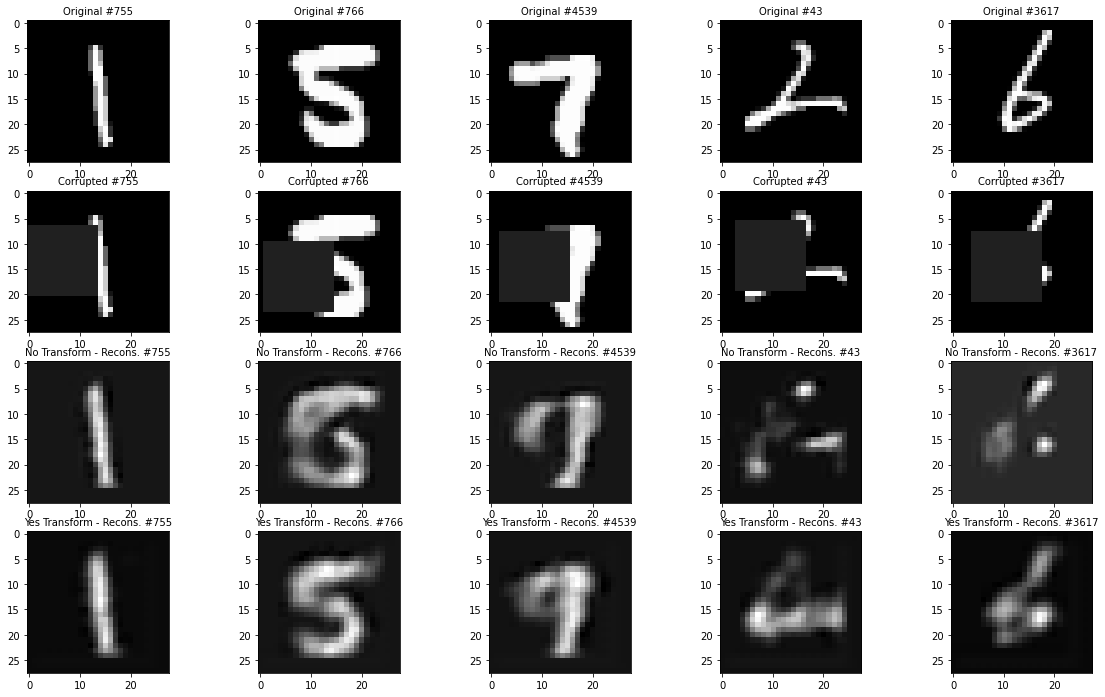

In [18]:
f, ax = plt.subplots(4, 5, figsize=(20, 12))

idxs = np.random.choice(X_test.shape[0], 5)
images = X_test[idxs].unsqueeze(1)
images_corrupted = corrupt_image_batch(images)

for i, idx in enumerate(idxs):
    ax[0, i].imshow(images[i].squeeze() * std + mean, cmap='gray')  # Note: Undo mean and std normalization before viewing image
    ax[0, i].set_title(f'Original #{idx}', fontsize=10)
    
    ax[1, i].imshow(images_corrupted[i].squeeze() * std + mean, cmap='gray')  # Note: Undo mean and std normalization before viewing image
    ax[1, i].set_title(f'Corrupted #{idx}', fontsize=10)
    
    # add batch and channel dimensions before passing through the model and squeeze them out later
    xr = m1(images_corrupted[i].view(1, 1, 28, 28)).detach().squeeze()
    ax[2, i].imshow(xr * std + mean, cmap='gray')  # Note: Undo mean and std normalization before viewing image
    ax[2, i].set_title(f'No Transform - Recons. #{idx}', fontsize=10)
    
    # add batch and channel dimensions before passing through the model and squeeze them out later
    xr = m2(images_corrupted[i].view(1, 1, 28, 28)).detach().squeeze()
    ax[3, i].imshow(xr * std + mean, cmap='gray')  # Note: Undo mean and std normalization before viewing image
    ax[3, i].set_title(f'Yes Transform - Recons. #{idx}', fontsize=10)

# 2. (Bonus) AutoEncoders as a non-linear PCA

In this exercise, we will compare autoencoders versus PCA for dimensionality reduction. We will note their
usefulness on the end goal of training a linear model using the extracted low-dimensional features.

In the first few labs, we used images as 784 dimensional vectors. Here, you will use either autoencoders or PCA on the training dataset to project the data onto a lower dimension d. You will then train a multinomial logistic regression model with scikit-learn and keep track of the test accuracy.

In [14]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

In [15]:
num_components_list = [10, 25, 50, 100]

### Download and Process MINST dataset
Perform the same preprocessing as in this week’s lab.

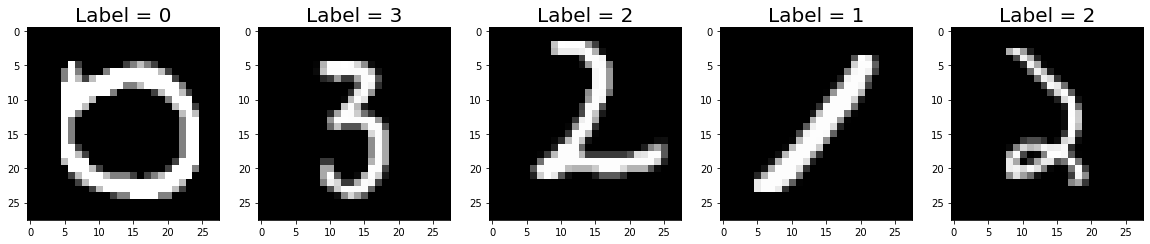

In [16]:
f, ax = plt.subplots(1, 5, figsize=(20, 4))
for i, idx in enumerate(np.random.choice(X_train.shape[0], 5)):
    ax[i].imshow(X_train[idx].squeeze() * std + mean, cmap='gray', vmin=0, vmax=255)
    ax[i].set_title(f'Label = {y_train[idx]}', fontsize=20)

### PCA Projections
Given a lower dimension d, use PCA to reduce the dimensionality of the training set to d dimensions.
Transform the test set by projecting on to the same space. You may use scikit-learn’s PCA implementation.

In [17]:
X_train_2d = X_train.view((X_train.shape[0], -1))
X_test_2d = X_test.view((X_test.shape[0], -1))

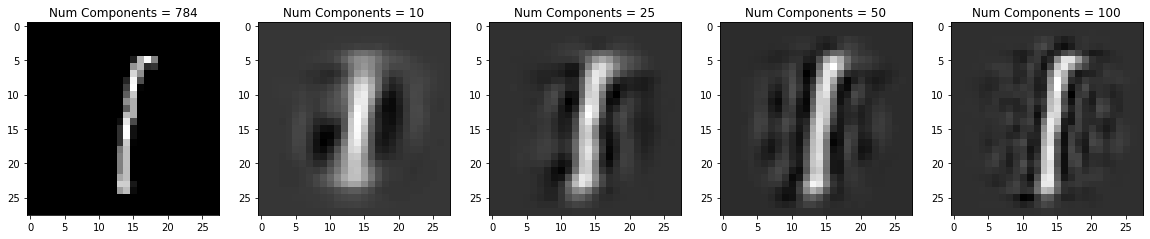

In [18]:
f, ax = plt.subplots(1, len(num_components_list)+1, figsize=(20, 10))
idx = np.random.choice(X_train_2d.shape[0], 1)

ax[0].imshow(X_train[idx].squeeze() * std + mean, cmap='gray')  # Note: Undo mean and std normalization before viewing image
ax[0].set_title(f'Num Components = {28*28}', fontsize=12)

for i, num_components in enumerate(num_components_list):
    pca = PCA(n_components = num_components)
    principalComponents = pca.fit(X_train_2d)
    
    # Apply transform to both the training set and the test set.
    train_img = pca.transform(X_train_2d)
    test_img = pca.transform(X_test_2d)
    
    approximation = pca.inverse_transform(train_img)
    
    ax[i+1].set_title(f'Num Components = {num_components}', fontsize=12)
    ax[i+1].imshow(torch.tensor(approximation[idx].reshape(28,28).squeeze()) * std + mean, cmap='gray')  # Note: Undo mean and std normalization before viewing image


### Multinomial logistic Regression

In [19]:
def get_accuracy(y_true, y_pred):
    return np.mean(y_pred == y_true)

In [20]:
log_reg_model = LogisticRegression(max_iter=200)
log_reg_model.fit(train_img, y_train)

/home/apoorvsharma/anaconda3/envs/data598/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=200)

In [21]:
y_pred = log_reg_model.predict(test_img)
print(get_accuracy(y_pred, y_test.numpy()) * 100)

89.68


### Define AutoEncoder and Training Functions
These need to be re-written/re-defined since they were changed for #1. 

The same 

In [22]:
def loss_function(true_images, reconstructed_images):  # square loss
    residual = (true_images - reconstructed_images).view(-1)  # flatten into a vector
    # return the average over examples
    return 0.5 * torch.norm(residual) ** 2 / (true_images.shape[0])

def compute_objective(model, images):
    # reshape images from (B, 28, 28) -> (B, 1, 28, 28) as required by the model
    images = images.unsqueeze(1)  # Add channel dimension
    reconstructed_images = model(images)
    return loss_function(images, reconstructed_images)

In [23]:
@torch.no_grad()
def compute_logs(model, verbose=False): # Only report loss
    train_loss = compute_objective(model, X_train)
    test_loss = compute_objective(model, X_test)
    if verbose:
        print('Train Loss = {:.3f}, Test Loss = {:.3f}'.format(
                train_loss.item(), test_loss.item(),
    ))
    return (train_loss, test_loss)

def minibatch_sgd_one_pass(model, X, learning_rate, batch_size, verbose=False):
    num_examples = X.shape[0]
    average_loss = 0.0
    num_updates = int(round(num_examples / batch_size))
    for i in range(num_updates):
        idxs = np.random.choice(num_examples, size=(batch_size,)) 
        # compute the objective. 
        objective = compute_objective(model, X[idxs]) 
        average_loss = 0.99 * average_loss + 0.01 * objective.item()
        if verbose and (i+1) % 100 == 0:
            print("{:.3f}".format(average_loss))
        
        # Exercise:
        # compute the gradient using automatic differentiation
        gradients = torch.autograd.grad(outputs=objective, inputs=model.parameters())

        # Perform the SGD update
        with torch.no_grad():
            for (w, g) in zip(model.parameters(), gradients):
                w -= learning_rate * g
                
    return model

### Dimension Reduction Analysis

Here we perform the following steps, for the following values of d `[10, 25, 50, 100]`:
1. Given a lower dimension d, use PCA to reduce the dimensionality of the training set to d dimensions. Transform the test set by projecting on to the same space.
2. Train an autoencoder using the same settings as the lab, but with a hidden dimension as d. Train it for 40 epochs. Use the encoder to obtain d-dimensional representations for all training and test images.
3. Train a multinomial logistic regression model with scikit-learn using each of the representations you have obtained.

In [28]:
initial_learning_rate = 2.5e-4
learning_rate_threshold = 10
batch_size = 1
num_epochs = 40

In [29]:
pca_accuracy = []
ae_accuracy = []

In [30]:
for i, num_components in enumerate(num_components_list):
    
    print(f'Starting dimension reduction to {num_components} components')
    
    # STEP 1: Dimension Reduction using PCA
    print(f'\tStarting PCA')
    pca = PCA(n_components = num_components)
    principalComponents = pca.fit(X_train_2d)
    
    # Apply transform to both the training set and the test set.
    train_img_pca = pca.transform(X_train_2d)
    test_img_pca = pca.transform(X_test_2d)
    print(f'\tFinished PCA')
    
    # STEP 2: Dimension Reduction using AutoEncoder
    print(f'\tStarting AutoEncoder Training')
    logs = []
    model = AutoEncoder(num_components)
    print(f'\t\tIteration 0, LR: {initial_learning_rate}', end=', ')
    logs.append(compute_logs(model, verbose=True))

    for j in range(num_epochs):
        # step decay learning rate schedule
        num_epoch = j + 1
        learning_rate = initial_learning_rate / ( math.pow(2, math.floor(num_epoch/learning_rate_threshold)) )

        model = minibatch_sgd_one_pass(model, X_train, learning_rate, batch_size=batch_size, verbose=False)
        print(f'\t\tIteration {num_epoch}, LR: {learning_rate}', end=', ')
        logs.append(compute_logs(model, verbose=True))

    with open('./models/q2_logs_nc_{num_components}.pkl', 'wb') as f:
        pickle.dump(logs, f)

    # save the model parms
    torch.save(model.state_dict(), f'./models/q2_parms_nc_{num_components}.pt')
    
    # Obtain encoded traina and test images
    train_img_ae = model.encode_images(X_train.unsqueeze(1))
    test_img_ae = model.encode_images(X_test.unsqueeze(1))
    
    print(f'\tDone AutoEncoder Training')
    
    # STEP 3a Create Logistic Regression Models for each reduction method
    log_reg_model_pca = LogisticRegression(max_iter=200)
    log_reg_model_pca.fit(train_img_pca, y_train)
    
    log_reg_model_ae = LogisticRegression(max_iter=200)
    log_reg_model_ae.fit(train_img_ae.detach().numpy(), y_train)
    
    # STEP 3b: Predict and get accuracy from each model
    # Accuracy for PCA model
    y_pred = log_reg_model_pca.predict(test_img_pca)
    pca_accuracy.append(get_accuracy(y_pred, y_test.numpy()) * 100)
    
    # Accuracy for AutoEncoder model
    y_pred = log_reg_model_ae.predict(test_img_ae.detach().numpy())
    ae_accuracy.append(get_accuracy(y_pred, y_test.numpy()) * 100)
    
    print(f'AE Acc: {ae_accuracy[-1]:.2f}, PCA Acc: {pca_accuracy[-1]:.2f}')

Starting dimension reduction to 10 components
	Starting PCA
	Finished PCA
	Starting AutoEncoder Training
		Iteration 0, LR: 0.00025, Train Loss = 398.408, Test Loss = 406.882
		Iteration 1, LR: 0.00025, Train Loss = 388.082, Test Loss = 395.253
		Iteration 2, LR: 0.00025, Train Loss = 125.771, Test Loss = 126.142
		Iteration 3, LR: 0.00025, Train Loss = 118.647, Test Loss = 118.829
		Iteration 4, LR: 0.00025, Train Loss = 121.273, Test Loss = 121.887
		Iteration 5, LR: 0.00025, Train Loss = 114.497, Test Loss = 114.543
		Iteration 6, LR: 0.00025, Train Loss = 112.021, Test Loss = 112.409
		Iteration 7, LR: 0.00025, Train Loss = 110.072, Test Loss = 110.112
		Iteration 8, LR: 0.00025, Train Loss = 108.094, Test Loss = 108.636
		Iteration 9, LR: 0.00025, Train Loss = 110.723, Test Loss = 111.919
		Iteration 10, LR: 0.000125, Train Loss = 103.235, Test Loss = 104.026
		Iteration 11, LR: 0.000125, Train Loss = 101.062, Test Loss = 101.586
		Iteration 12, LR: 0.000125, Train Loss = 101.835,

/home/apoorvsharma/anaconda3/envs/data598/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/apoorvsharma/anaconda3/envs/data598/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

AE Acc: 88.13, PCA Acc: 80.59
Starting dimension reduction to 25 components
	Starting PCA
	Finished PCA
	Starting AutoEncoder Training
		Iteration 0, LR: 0.00025, Train Loss = 392.124, Test Loss = 399.276
		Iteration 1, LR: 0.00025, Train Loss = 110.442, Test Loss = 109.876
		Iteration 2, LR: 0.00025, Train Loss = 77.722, Test Loss = 77.165
		Iteration 3, LR: 0.00025, Train Loss = 73.069, Test Loss = 72.832
		Iteration 4, LR: 0.00025, Train Loss = 72.282, Test Loss = 71.602
		Iteration 5, LR: 0.00025, Train Loss = 70.758, Test Loss = 70.191
		Iteration 6, LR: 0.00025, Train Loss = 65.048, Test Loss = 64.995
		Iteration 7, LR: 0.00025, Train Loss = 62.681, Test Loss = 62.431
		Iteration 8, LR: 0.00025, Train Loss = 61.486, Test Loss = 61.192
		Iteration 9, LR: 0.00025, Train Loss = 61.099, Test Loss = 61.214
		Iteration 10, LR: 0.000125, Train Loss = 57.536, Test Loss = 57.585
		Iteration 11, LR: 0.000125, Train Loss = 56.843, Test Loss = 56.884
		Iteration 12, LR: 0.000125, Train Loss 

/home/apoorvsharma/anaconda3/envs/data598/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/apoorvsharma/anaconda3/envs/data598/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

AE Acc: 90.73, PCA Acc: 88.52
Starting dimension reduction to 50 components
	Starting PCA
	Finished PCA
	Starting AutoEncoder Training
		Iteration 0, LR: 0.00025, Train Loss = 393.328, Test Loss = 400.636
		Iteration 1, LR: 0.00025, Train Loss = 76.671, Test Loss = 76.322
		Iteration 2, LR: 0.00025, Train Loss = 62.838, Test Loss = 62.395
		Iteration 3, LR: 0.00025, Train Loss = 57.246, Test Loss = 56.715
		Iteration 4, LR: 0.00025, Train Loss = 54.207, Test Loss = 54.016
		Iteration 5, LR: 0.00025, Train Loss = 75.574, Test Loss = 75.448
		Iteration 6, LR: 0.00025, Train Loss = 50.080, Test Loss = 49.592
		Iteration 7, LR: 0.00025, Train Loss = 53.834, Test Loss = 54.251
		Iteration 8, LR: 0.00025, Train Loss = 46.501, Test Loss = 46.436
		Iteration 9, LR: 0.00025, Train Loss = 45.986, Test Loss = 46.062
		Iteration 10, LR: 0.000125, Train Loss = 39.784, Test Loss = 39.671
		Iteration 11, LR: 0.000125, Train Loss = 39.110, Test Loss = 38.953
		Iteration 12, LR: 0.000125, Train Loss = 

/home/apoorvsharma/anaconda3/envs/data598/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/apoorvsharma/anaconda3/envs/data598/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

AE Acc: 90.40, PCA Acc: 89.98
Starting dimension reduction to 100 components
	Starting PCA
	Finished PCA
	Starting AutoEncoder Training
		Iteration 0, LR: 0.00025, Train Loss = 400.061, Test Loss = 411.124
		Iteration 1, LR: 0.00025, Train Loss = 67.329, Test Loss = 66.640
		Iteration 2, LR: 0.00025, Train Loss = 56.515, Test Loss = 56.282
		Iteration 3, LR: 0.00025, Train Loss = 45.893, Test Loss = 45.705
		Iteration 4, LR: 0.00025, Train Loss = 76.234, Test Loss = 76.851
		Iteration 5, LR: 0.00025, Train Loss = 40.744, Test Loss = 40.700
		Iteration 6, LR: 0.00025, Train Loss = 43.252, Test Loss = 43.148
		Iteration 7, LR: 0.00025, Train Loss = 38.617, Test Loss = 38.480
		Iteration 8, LR: 0.00025, Train Loss = 39.971, Test Loss = 40.016
		Iteration 9, LR: 0.00025, Train Loss = 37.326, Test Loss = 37.274
		Iteration 10, LR: 0.000125, Train Loss = 32.580, Test Loss = 32.562
		Iteration 11, LR: 0.000125, Train Loss = 32.723, Test Loss = 32.687
		Iteration 12, LR: 0.000125, Train Loss =

/home/apoorvsharma/anaconda3/envs/data598/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AE Acc: 90.31, PCA Acc: 89.70


/home/apoorvsharma/anaconda3/envs/data598/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Output Analysis
Make a plot with d on the x-axis and the best test accuracy of the logistic regression model on the y-axis with the d-dimensional representations. The plot should have two lines, corresponding to PCA and autoencoders.

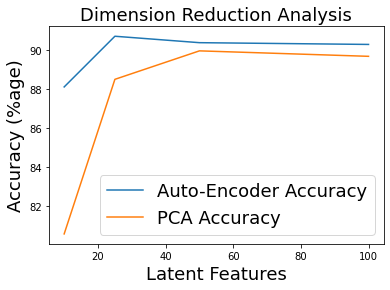

In [31]:
plt.plot(num_components_list, ae_accuracy, label="Auto-Encoder Accuracy")
plt.plot(num_components_list, pca_accuracy, label="PCA Accuracy")
plt.title('Dimension Reduction Analysis', fontsize=18)
plt.ylabel('Accuracy (%age)', fontsize=18)
plt.xlabel('Latent Features', fontsize=18)
plt.legend(fontsize=18)

Based on these observations, could you speculate why one of the two might be better or worse than the
other?

PCA is essentially a linear transformation. However, AutoEncoders can map complex non-linear functions. As a result, for image data, auto-encoders perform better at reconstruction. 